In [1]:
import warnings
warnings.filterwarnings("ignore")
import mesa
import mesa_geo as mg
from mesa import Model
from mesa import Agent
import random
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
import matplotlib.pyplot as plt

- agents - people, gold
- take gold and move
- grid has resources distributed
- people move one cell at a time

Todo: people move where there is more gold ?

In [2]:
class GoldPatch(Agent):
    def __init__(self, unique_id: int, model: Model, pos, gold):
        super().__init__(unique_id, model)
        self.pos = pos
        self.gold = gold

In [3]:
class PeopleAgent(Agent):
    def __init__(self, unique_id: int, model: Model, initial_gold):
        super().__init__(unique_id, model)
        self.gold = initial_gold
    
    def step(self):
        # move to adjacent cell
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center = False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

        # see for gold at new position
        is_gold = self.model.grid.get_cell_list_contents([self.pos])
        for new_gold in is_gold:
            if isinstance(new_gold, GoldPatch):
                self.gold += new_gold.gold
                new_gold.gold = 0
                self.model.grid.remove_agent(new_gold)


In [4]:
class SugarscapeModel(Model):
    def __init__(self, N, width, height, initial_gold):
        self.agents = N
        self.width = width
        self.height = height
        self.initial_gold = initial_gold
        self.grid = MultiGrid(width=width, height=height, torus=True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            {"Gold": lambda m: self.count_type(m, "Gold")}
        )

        # create agents (people)
        for i in range(self.agents):
            p = PeopleAgent(i, self, initial_gold=initial_gold)
            self.schedule.add(p)
            x, y = self.grid.find_empty()
            self.grid.place_agent(p, (x,y))

        # ccreate gold patches
        for i in range(5):
            # x, y = self.grid.find_empty()
            x = random.randrange(self.width)
            y = random.randrange(self.height)
            # random gold value
            gold = random.randint(1, 10)
            patch = GoldPatch(i+self.agents, self, (x,y), gold=gold) # ASK!!!!
            self.grid.place_agent(patch, (x,y))
            self.schedule.add(patch)    

    def step(self):
        self.schedule.step()

In [5]:
def visualize(model):
    plt.clf()
    fig, ax = plt.subplots()
    for agent in model.schedule.agents:
        if isinstance(agent, PeopleAgent):
            ax.scatter(agent.pos[0], agent.pos[1], color = 'red')
        if isinstance(agent, GoldPatch):
            ax.scatter(agent.pos[0], agent.pos[1], color = 'yellow')
    plt.show()

<Figure size 432x288 with 0 Axes>

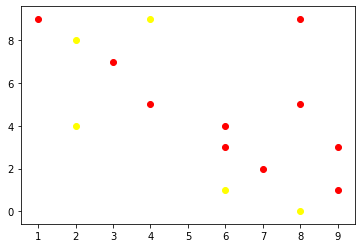

TypeError: 'NoneType' object is not subscriptable

<Figure size 432x288 with 0 Axes>

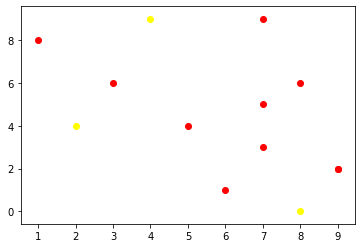

In [6]:
model = SugarscapeModel(N=10, width=10,height=10,initial_gold=10)
for i in range(10):
    model.step()
    visualize(model)